Towards Universal Fake Image Detectors that
Generalize Across Generative Models


---



This Paper introduces the Idea of not training models for the task of deepfake detection but rather taking a large model trained on ImageNet and CLIP to be used for creating embeddings and projecting the input image into a high dimentional space.

The Paper Simply takes the embeddings and tries two methods : KNN and Linear Classification for the said task.

Here I have experimented with ImageNet and CLIP Vit-B-16 and after that KNN performance is compared to that of XGBoost algorithm. A futher step of Autoencoder is added to see if accuracy is maintained at a lower dimention.

Using ImageNet Vit-B-16 model

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.ndimage.filters import gaussian_filter

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the autoencoder model
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, latent_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x, labels):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded, labels

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None, apply_gaussian_blur=False, gaussian_sigma=None):
        self.file_list = file_list
        self.transform = transform
        self.apply_gaussian_blur = apply_gaussian_blur
        self.gaussian_sigma = gaussian_sigma

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        image = Image.open(file_path).convert("RGB")

        # Apply Gaussian blur if specified
        if self.apply_gaussian_blur and self.gaussian_sigma:
            image = gaussian_blur(image, self.gaussian_sigma)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

def gaussian_blur(img, sigma):
    img = np.array(img)

    gaussian_filter(img[:,:,0], output=img[:,:,0], sigma=sigma)
    gaussian_filter(img[:,:,1], output=img[:,:,1], sigma=sigma)
    gaussian_filter(img[:,:,2], output=img[:,:,2], sigma=sigma)

    return Image.fromarray(img)

# Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name).to(device)

# checkpoint = torch.load('path/to/auto.pth')
# model.load_state_dict(checkpoint)

# checkpoint_path = '/content/drive/MyDrive/ViT-B-16.pt'
# checkpoint = torch.load(checkpoint_path)

# checkpoint
# # Extract the necessary information from the checkpoint
# model_state_dict = checkpoint['model']
# config = checkpoint['config']

# # Load the ViT model with its pre-trained weights
# model = ViTForImageClassification(config)
# model.load_state_dict(model_state_dict)


# Remove the classification head
model.classifier = torch.nn.Identity().to(device)

# Set up optimizer and loss function for fine-tuning ViT
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Load your dataset
# data_path = '/content/drive/MyDrive/diffusion_datasets/dalle'
# data_path = '/content/drive/MyDrive/CNN_synth_testset/biggan'
# data_path = '/content/drive/MyDrive/Combined model'
data_path = '/content/drive/MyDrive/CNN_synth_testset.zip (Unzipped Files)/stargan'

classes = os.listdir(data_path)
label_to_class = {i: class_name for i, class_name in enumerate(classes)}
class_to_label = {class_name: i for i, class_name in enumerate(classes)}

file_list = []

for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    class_label = class_to_label[class_name]
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        file_list.append((file_path, class_label))

train_file_list, test_file_list = train_test_split(file_list, test_size=0.999, random_state=42)

# Create custom datasets for training and testing
train_dataset = CustomDataset(file_list=train_file_list, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]), apply_gaussian_blur=False, gaussian_sigma=2.0)
test_dataset = CustomDataset(file_list=test_file_list, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]), apply_gaussian_blur=False, gaussian_sigma=2.0)

# Create a custom dataset for the entire dataset
# full_dataset = CustomDataset(file_list=file_list, transform=transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ]))

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create a data loader for the entire dataset
full_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)



# Extract the embedding tensor (768 dimensions) for the entire dataset
model.eval()

embedding_tensors = []
labels_list = []

# Extract embedding tensors from the evaluation loop
model.eval()
with torch.no_grad():
    for inputs, labels in full_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        embedding_tensor = outputs.logits
        embedding_tensors.append(embedding_tensor)
        labels_list.append(labels)

# Concatenate the lists to get the final embedding tensor
embedding_tensor = torch.cat(embedding_tensors, dim=0)
labels = torch.cat(labels_list, dim=0)

print("ViT Embedding Tensor Shape:", embedding_tensor.shape)

import pandas as pd

output1_df = pd.DataFrame(embedding_tensor.tolist())  # Transpose the matrix before creating DataFrame
output1_df['label'] = labels.cpu().numpy()  # Add labels to the DataFrame
output1_df.to_csv('/content/drive/MyDrive/embedded_output.csv', index=False)


# Define and train the autoencoder
input_dim = embedding_tensor.shape[1]  # Assuming the input dimension is the size of the ViT embedding
latent_dim = 200  # Desired latent dimension
autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
autoencoder_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
autoencoder_criterion = torch.nn.MSELoss()

# Flatten the embedding tensor before passing it to the autoencoder
# flat_embedding_tensor = embedding_tensor.view(embedding_tensor.size(0), embedding_tensor.size(1), -1)
flat_embedding_tensor = embedding_tensor.view(embedding_tensor.size(0), -1)


# Create labels for the autoencoded tensor (fake or real)
autoencoded_labels = labels.repeat(latent_dim, 1).t().flatten()

# Train the autoencoder
num_autoencoder_epochs = 50
for epoch in range(num_autoencoder_epochs):
    print(f"Epoch {epoch + 1}/{num_autoencoder_epochs}")
    autoencoder_optimizer.zero_grad()
    encoded, decoded, autoencoded_labels = autoencoder(flat_embedding_tensor, autoencoded_labels)
    autoencoder_loss = autoencoder_criterion(decoded, flat_embedding_tensor)
    autoencoder_loss.backward()
    autoencoder_optimizer.step()

# Save the trained autoencoder model
torch.save(autoencoder.state_dict(), '/content/drive/MyDrive/autoencoder_model.pth')

# Save the autoencoded tensor to a CSV file

output_df = pd.DataFrame(encoded.detach().cpu().numpy().reshape(-1, latent_dim))  # Transpose the matrix before creating DataFrame
output_df['label'] = labels.cpu().numpy()  # Add labels to the DataFrame
output_df.to_csv('/content/drive/MyDrive/autoencoder_output.csv', index=False)


<ipython-input-3-307a3ba6d179>:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT Embedding Tensor Shape: torch.Size([3373, 768])
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Using CLIP Vit-B-16

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the autoencoder model
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, latent_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x, labels):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded, labels

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None, apply_gaussian_blur=False, gaussian_sigma=None):
        self.file_list = file_list
        self.transform = transform
        self.apply_gaussian_blur = apply_gaussian_blur
        self.gaussian_sigma = gaussian_sigma

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        image = Image.open(file_path).convert("RGB")

        # Apply Gaussian blur if specified
        if self.apply_gaussian_blur and self.gaussian_sigma:
            image = gaussian_blur(image, self.gaussian_sigma)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

def gaussian_blur(img, sigma):
    img = np.array(img)

    gaussian_filter(img[:,:,0], output=img[:,:,0], sigma=sigma)
    gaussian_filter(img[:,:,1], output=img[:,:,1], sigma=sigma)
    gaussian_filter(img[:,:,2], output=img[:,:,2], sigma=sigma)

    return Image.fromarray(img)

# Load the pre-trained CLIP model and processor
model_name = "openai/clip-vit-large-patch14"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)

# Remove the classification head
model.logit_scale = torch.nn.Parameter(torch.ones(1, device=device))

# Set up optimizer and loss function for fine-tuning CLIP
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Load your dataset
# data_path = '/content/drive/MyDrive/diffusion_datasets/dalle'
data_path = '/content/drive/MyDrive/CNN_synth_testset.zip (Unzipped Files)/stargan'

classes = os.listdir(data_path)
label_to_class = {i: class_name for i, class_name in enumerate(classes)}
class_to_label = {class_name: i for i, class_name in enumerate(classes)}

file_list = []

for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    class_label = class_to_label[class_name]
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        file_list.append((file_path, class_label))

train_file_list, test_file_list = train_test_split(file_list, test_size=0.99, random_state=42)

# Create custom datasets for training and testing
train_dataset = CustomDataset(file_list=train_file_list, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]), apply_gaussian_blur=False, gaussian_sigma=2.0)
test_dataset = CustomDataset(file_list=test_file_list, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
]), apply_gaussian_blur=False, gaussian_sigma=2.0)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create a data loader for the entire dataset
full_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

# Extract embedding tensors from the evaluation loop
embedding_tensors = []
labels_list = []

model.eval()
with torch.no_grad():
    for inputs, labels in full_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = processor(text="", images=inputs, return_tensors="pt").to(device)
        outputs = model(**inputs)
        embedding_tensor = outputs.vision_model_output.pooler_output
        embedding_tensors.append(embedding_tensor)
        labels_list.append(labels)

# Concatenate the lists to get the final embedding tensor
embedding_tensor = torch.cat(embedding_tensors, dim=0)
labels = torch.cat(labels_list, dim=0)

print("CLIP Embedding Tensor Shape:", embedding_tensor.shape)

output1_df = pd.DataFrame(embedding_tensor.tolist())  # Transpose the matrix before creating DataFrame
output1_df['label'] = labels.cpu().numpy()  # Add labels to the DataFrame
output1_df.to_csv('/content/drive/MyDrive/embedded_output_clip.csv', index=False)

# Define and train the autoencoder
input_dim = embedding_tensor.shape[1]  # Assuming the input dimension is the size of the CLIP embedding
latent_dim = 75   # Desired latent dimension
autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
autoencoder_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
autoencoder_criterion = torch.nn.MSELoss()

# Flatten the embedding tensor before passing it to the autoencoder
flat_embedding_tensor = embedding_tensor.view(embedding_tensor.size(0), -1)

# Create labels for the autoencoded tensor (fake or real)
autoencoded_labels = labels.repeat(latent_dim, 1).t().flatten()

# Train the autoencoder
num_autoencoder_epochs = 50
for epoch in range(num_autoencoder_epochs):
    print(f"Epoch {epoch + 1}/{num_autoencoder_epochs}")
    autoencoder_optimizer.zero_grad()
    encoded, decoded, autoencoded_labels = autoencoder(flat_embedding_tensor, autoencoded_labels)
    autoencoder_loss = autoencoder_criterion(decoded, flat_embedding_tensor)
    autoencoder_loss.backward()
    autoencoder_optimizer.step()

# Save the trained autoencoder model
torch.save(autoencoder.state_dict(), '/content/drive/MyDrive/autoencoder_model_clip.pth')

# Save the autoencoded tensor to a CSV file
output_df = pd.DataFrame(encoded.detach().cpu().numpy().reshape(-1, latent_dim))  # Transpose the matrix before creating DataFrame
output_df['label'] = labels.cpu().numpy()  # Add labels to the DataFrame
output_df.to_csv('/content/drive/MyDrive/autoencoder_output_clip.csv', index=False)


<ipython-input-1-778cde12c7e7>:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


CLIP Embedding Tensor Shape: torch.Size([3343, 1024])
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


T-sne plot for ImageNet Vit-B-16

0       1
1       1
2       1
3       1
4       0
       ..
3368    1
3369    0
3370    0
3371    0
3372    1
Name: label, Length: 3373, dtype: int64
(3373, 2)


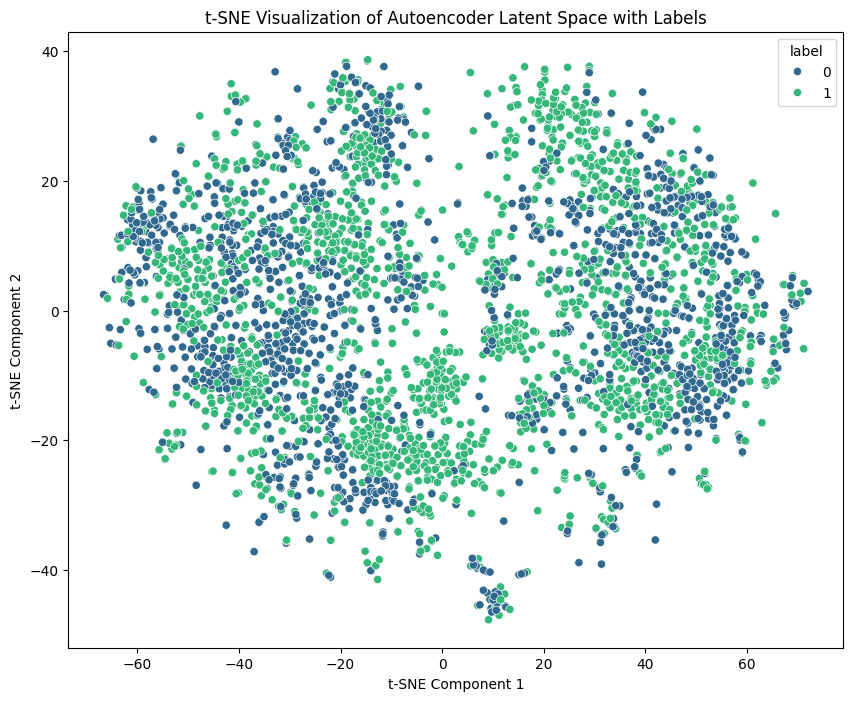

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load your encoded data from the CSV file
encoded_data = pd.read_csv('/content/drive/MyDrive/embedded_output.csv')

# Load labels from the original dataset
labels = encoded_data['label']
print(labels)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_data)
print(tsne_result.shape)

# Ensure the lengths match
labels = labels[:len(tsne_result)]

# Create a DataFrame with t-SNE results and labels
tsne_df = pd.DataFrame(tsne_result, columns=['tsne_1', 'tsne_2'])
tsne_df['label'] = labels

# Plot the t-SNE results with color-coded labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_df, palette="viridis", legend="full")
plt.title('t-SNE Visualization of Autoencoder Latent Space with Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


T-sne plot for Clip Vit B-16

0       0
1       0
2       0
3       1
4       0
       ..
3338    1
3339    1
3340    1
3341    0
3342    0
Name: label, Length: 3343, dtype: int64
(3343, 2)


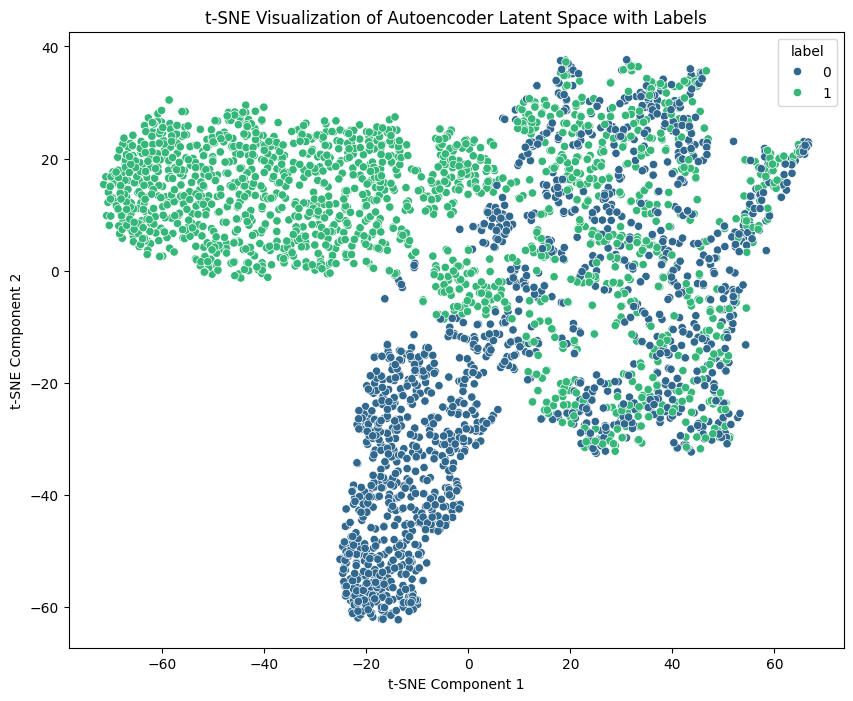

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load your encoded data from the CSV file
encoded_data = pd.read_csv('/content/drive/MyDrive/embedded_output_clip.csv')

# Load labels from the original dataset
labels = encoded_data['label']
print(labels)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_data)
print(tsne_result.shape)

# Ensure the lengths match
labels = labels[:len(tsne_result)]

# Create a DataFrame with t-SNE results and labels
tsne_df = pd.DataFrame(tsne_result, columns=['tsne_1', 'tsne_2'])
tsne_df['label'] = labels

# Plot the t-SNE results with color-coded labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_df, palette="viridis", legend="full")
plt.title('t-SNE Visualization of Autoencoder Latent Space with Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()




---


Dalle -->


---



ImageNet Vit-B-16 using XGBoost performance:

In [ ]:
#Xgboost on embedded data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')



def train_and_evaluate_xgboost(encoded_data, labels, test_size=0.1, random_state=42):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train XGBoost classifier
    xgboost_classifier = XGBClassifier()  # Use default parameters, you can customize them if needed
    xgboost_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = xgboost_classifier.predict(X_test)
    print(y_pred_test)
    print(y_test)
    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # if(accuracy_test>max_accuracy_test):

    #     max_accuracy_test = random_state

    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/embedded_output.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate XGBoost on the original dataset
# for i in range(20,50):
#   max_accuracy_test = 0
train_and_evaluate_xgboost(encoded_orig, labels_orig)
  # print(max_accuracy_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0
 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0
 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1
 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 0
 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0
 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0
 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0
 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 



performance with ImageNet and KNN (control experiment):

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def train_and_evaluate_knn(encoded_data, labels, test_size=0.05, random_state=42, n_neighbors=1):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train kNN classifier with cosine distance metric
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    knn_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = knn_classifier.predict(X_test)

    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/embedded_output.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate kNN with cosine distance on the original dataset
train_and_evaluate_knn(encoded_orig, labels_orig)


Test Accuracy: 82.27%


performance with ImageNet vit autoencoded XGBoost:
(latent dimention is 200)

In [ ]:
#Xgboost on embedded data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')



def train_and_evaluate_xgboost(encoded_data, labels, test_size=0.07, random_state=45):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train XGBoost classifier
    xgboost_classifier = XGBClassifier()  # Use default parameters, you can customize them if needed
    xgboost_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = xgboost_classifier.predict(X_test)
    print(y_pred_test)
    print(y_test)
    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # if(accuracy_test>max_accuracy_test):

    #     max_accuracy_test = random_state

    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/autoencoder_output.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate XGBoost on the original dataset
# for i in range(20,50):
#   max_accuracy_test = 0
train_and_evaluate_xgboost(encoded_orig, labels_orig)
  # print(max_accuracy_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1
 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1
 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1
 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1
 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1
 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1
 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0
 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 

Performance of CLIP Vit-B-16

In [ ]:
#Xgboost on embedded data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')



def train_and_evaluate_xgboost(encoded_data, labels, test_size=0.07, random_state=45):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train XGBoost classifier
    xgboost_classifier = XGBClassifier()  # Use default parameters, you can customize them if needed
    xgboost_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = xgboost_classifier.predict(X_test)
    print(y_pred_test)
    print(y_test)
    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # if(accuracy_test>max_accuracy_test):

    #     max_accuracy_test = random_state

    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/embedded_output.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate XGBoost on the original dataset
# for i in range(20,50):
#   max_accuracy_test = 0
train_and_evaluate_xgboost(encoded_orig, labels_orig)
  # print(max_accuracy_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1
 0 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1
 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1
 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1
 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1
 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1
 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1
 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 

---

Glide_100_27

---



ImageNet Vit B-16 Model Performance


Embedded output performance

In [ ]:
#Xgboost on embedded data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')



def train_and_evaluate_xgboost(encoded_data, labels, test_size=0.05, random_state=45):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train XGBoost classifier
    xgboost_classifier = XGBClassifier()  # Use default parameters, you can customize them if needed
    xgboost_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = xgboost_classifier.predict(X_test)
    print(y_pred_test)
    print(y_test)
    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # if(accuracy_test>max_accuracy_test):

    #     max_accuracy_test = random_state

    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/embedded_output.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate XGBoost on the original dataset
# for i in range(20,50):
#   max_accuracy_test = 0
train_and_evaluate_xgboost(encoded_orig, labels_orig)
  # print(max_accuracy_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1]
[0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 

Autoencoder performance

In [ ]:
#Xgboost on embedded data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')



def train_and_evaluate_xgboost(encoded_data, labels, test_size=0.05, random_state=45):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train XGBoost classifier
    xgboost_classifier = XGBClassifier()  # Use default parameters, you can customize them if needed
    xgboost_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = xgboost_classifier.predict(X_test)
    print(y_pred_test)
    print(y_test)
    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # if(accuracy_test>max_accuracy_test):

    #     max_accuracy_test = random_state

    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/autoencoder_output.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate XGBoost on the original dataset
# for i in range(20,50):
#   max_accuracy_test = 0
train_and_evaluate_xgboost(encoded_orig, labels_orig)
  # print(max_accuracy_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1]
[0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 

CLIP ViT B-16 Model Performance

Embedded output performance

In [ ]:
#Xgboost on embedded data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')



def train_and_evaluate_xgboost(encoded_data, labels, test_size=0.1, random_state=45):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train XGBoost classifier
    xgboost_classifier = XGBClassifier()  # Use default parameters, you can customize them if needed
    xgboost_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = xgboost_classifier.predict(X_test)
    print(y_pred_test)
    print(y_test)
    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # if(accuracy_test>max_accuracy_test):

    #     max_accuracy_test = random_state

    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/embedded_output_clip.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate XGBoost on the original dataset
# for i in range(20,50):
#   max_accuracy_test = 0
train_and_evaluate_xgboost(encoded_orig, labels_orig)
  # print(max_accuracy_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1]
[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1
 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1
 1 1 0 0 1 1 

Autoencoder Output Performance

In [ ]:
#Xgboost on embedded data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')



def train_and_evaluate_xgboost(encoded_data, labels, test_size=0.05, random_state=45):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train XGBoost classifier
    xgboost_classifier = XGBClassifier()  # Use default parameters, you can customize them if needed
    xgboost_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = xgboost_classifier.predict(X_test)
    print(y_pred_test)
    print(y_test)
    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # if(accuracy_test>max_accuracy_test):

    #     max_accuracy_test = random_state

    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/autoencoder_output_clip.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate XGBoost on the original dataset
# for i in range(20,50):
#   max_accuracy_test = 0
train_and_evaluate_xgboost(encoded_orig, labels_orig)
  # print(max_accuracy_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1
 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1
 1 1 0 0 1 1 



---


StarGan -->


---



ImageNet Vit-B-16 model performance:

This model give a good accuracy of nearly 90%

In [ ]:
#Xgboost on embedded data

import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')



def train_and_evaluate_xgboost(encoded_data, labels, test_size=0.1, random_state=45):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train XGBoost classifier
    xgboost_classifier = XGBClassifier()  # Use default parameters, you can customize them if needed
    xgboost_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = xgboost_classifier.predict(X_test)
    print(y_pred_test)
    print(y_test)
    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # if(accuracy_test>max_accuracy_test):

    #     max_accuracy_test = random_state

    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/embedded_output.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate XGBoost on the original dataset
# for i in range(20,50):
#   max_accuracy_test = 0
train_and_evaluate_xgboost(encoded_orig, labels_orig)
  # print(max_accuracy_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0
 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0
 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0
 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1
 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1
 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1
 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0
 0 1 1 1 1]
[1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0
 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0
 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0

CLIP Vit-B-16 performace:
(the performacy of this is surprisingly bad , which is not the norm as for other datasets This model outperforms the other)

In [ ]:
#Xgboost on embedded data

import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Import XGBoost classifier
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')



def train_and_evaluate_xgboost(encoded_data, labels, test_size=0.1, random_state=45):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train XGBoost classifier
    xgboost_classifier = XGBClassifier()  # Use default parameters, you can customize them if needed
    xgboost_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = xgboost_classifier.predict(X_test)
    print(y_pred_test)
    print(y_test)
    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # if(accuracy_test>max_accuracy_test):

    #     max_accuracy_test = random_state

    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/embedded_output_clip.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate XGBoost on the original dataset
# for i in range(20,50):
#   max_accuracy_test = 0
train_and_evaluate_xgboost(encoded_orig, labels_orig)
  # print(max_accuracy_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1
 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1
 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0
 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1
 1 0]
[0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1
 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1

KNN on Clip Vit embeddings

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def train_and_evaluate_knn(encoded_data, labels, test_size=0.1, random_state=42, n_neighbors=9):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(encoded_data, labels, test_size=test_size, random_state=random_state)

    # Train kNN classifier with cosine distance metric
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    knn_classifier.fit(X_train, y_train)

    # Predict on the test dataset
    y_pred_test = knn_classifier.predict(X_test)

    # Evaluate accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f'Test Accuracy: {accuracy_test * 100:.2f}%')

# Load the original dataset with labels
original_data = pd.read_csv('/content/drive/MyDrive/embedded_output.csv')  # Replace with the actual path

# Assuming the 'label' column contains the labels (0 for fake, 1 for real)
labels_orig = original_data['label'].values
encoded_orig = original_data.drop(columns=['label']).to_numpy()

# Call the function to train and evaluate kNN with cosine distance on the original dataset
train_and_evaluate_knn(encoded_orig, labels_orig)


Test Accuracy: 75.15%


Conclusions:

->Clip Vit B-16 peroforms better than ImageNet Vit B-16 for the task at hand

->Autoencoding to a dimention of atleast 150 is needed for sufficient retention of information. below this dimention , accuracy will suffer.

->GANs in very specific cases will not be detected properly by Clip Vit but will be detected by ImageNet Vit.

->Gaussian noise can increase accuracy for diffusion models but the same is not true for Gans
